In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.preprocessing import scale
import geopandas as gpd
import contextily as ctx 
from sklearnex import patch_sklearn
patch_sklearn()


from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [17]:
grid = gpd.read_parquet(f"../output/{place}/p5-grid-output.pq")

In [18]:
grid.set_index(['row', 'col'], inplace=True)

In [19]:
geo_col = grid[['geometry']]

In [20]:
geo_col

geometry
row   col                                                     
98.0  224.0  POLYGON ((258725.960 675120.935, 258815.536 67...
      228.0  POLYGON ((259084.263 675109.206, 259173.839 67...
99.0  224.0  POLYGON ((258726.683 675009.019, 258816.260 67...
100.0 261.0  POLYGON ((262041.803 674789.759, 262131.382 67...
101.0 259.0  POLYGON ((261863.396 674683.587, 261952.976 67...
...                                                        ...
265.0 188.0  POLYGON ((255617.406 656552.381, 255707.121 65...
      217.0  POLYGON ((258219.109 656466.586, 258308.823 65...
267.0 212.0  POLYGON ((257771.974 656257.800, 257861.690 65...
268.0 213.0  POLYGON ((257862.407 656143.130, 257952.123 65...
269.0 211.0  POLYGON ((257683.691 656037.281, 257773.408 65...

[12173 rows x 1 columns]

In [21]:
colsubset = grid.head().columns.tolist()

In [22]:
grid.describe()

index  tess_area_IQR  tess_area_MeanWithinIQR  tess_area_Theil  \
count  12173.000000   12173.000000             12173.000000     12173.000000   
mean   10010.627043    2546.580749              6933.056894         0.077984   
std     5782.087618    6849.032429             22762.343222         0.120855   
min        4.000000       0.000000                59.223917         0.000000   
25%     4981.000000     309.110698               869.995597         0.004977   
50%    10043.000000     728.621523              1516.192815         0.037946   
75%    15062.000000    2250.758936              4078.918588         0.095632   
max    19958.000000  191742.279698            639193.313360         1.429081   

       tessellation_neighbours_IQR  tessellation_neighbours_MeanWithinIQR  \
count                 12173.000000                           12173.000000   
mean                      0.081940                               0.221928   
std                       0.070869                               0.097261   
min                       0.000000                               0.001035   
25%                       0.035575                               0.153257   
50%                       0.070139                               0.220516   
75%                       0.111122                               0.284377   
max                       1.667941                               0.836560   

       tessellation_neighbours_Theil  tess_convexity_IQR  \
count                   12173.000000        12173.000000   
mean                        0.018060            0.050949   
std                         0.028304            0.043476   
min                         0.000000            0.000000   
25%                         0.001557            0.025161   
50%                         0.010042            0.043863   
75%                         0.022203            0.065829   
max                         0.627305            0.558060   

       tess_convexity_MeanWithinIQR  tess_convexity_Theil  ...  \
count                  12173.000000          12173.000000  ...   
mean                       0.940371              0.000601  ...   
std                        0.043987              0.002504  ...   
min                        0.193143              0.000000  ...   
25%                        0.932019              0.000027  ...   
50%                        0.949367              0.000218  ...   
75%                        0.962464              0.000529  ...   
max                        1.000000              0.094385  ...   

       global_angular_closeness_IQR  global_angular_closeness_MeanWithinIQR  \
count                  1.157700e+04                            11577.000000   
mean                   1.917222e-04                                0.000748   
std                    2.710623e-20                                0.000000   
min                    1.917222e-04                                0.000748   
25%                    1.917222e-04                                0.000748   
50%                    1.917222e-04                                0.000748   
75%                    1.917222e-04                                0.000748   
max                    1.917222e-04                                0.000748   

       global_angular_closeness_Theil  global_angular_betweeness_IQR  \
count                    1.157700e+04                   11577.000000   
mean                     7.617103e-03                       0.000281   
std                      8.673992e-19                       0.000000   
min                      7.617103e-03                       0.000281   
25%                      7.617103e-03                       0.000281   
50%                      7.617103e-03                       0.000281   
75%                      7.617103e-03                       0.000281   
max                      7.617103e-03                       0.000281   

       global_angular_betweeness_MeanWithinIQR  \
count                             1.157700e+04   
me

In [23]:
grid_dropped = grid.fillna(0)
grid_dropped = grid_dropped[grid_dropped['building_count_x'] > 2]

In [24]:
# List of substrings to check in the column names
substrings = ['index', 'bID']

# Identify columns to drop
columns_to_drop = [col for col in grid_dropped.columns if any(substring in col for substring in substrings)]

# Drop the identified columns
grid_dropped = grid_dropped.drop(columns=columns_to_drop)

# Display the modified DataFrame
print(grid_dropped.columns.tolist())

['tess_area_IQR', 'tess_area_MeanWithinIQR', 'tess_area_Theil', 'tessellation_neighbours_IQR', 'tessellation_neighbours_MeanWithinIQR', 'tessellation_neighbours_Theil', 'tess_convexity_IQR', 'tess_convexity_MeanWithinIQR', 'tess_convexity_Theil', 'tess_covered_area_IQR', 'tess_covered_area_MeanWithinIQR', 'tess_covered_area_Theil', 'tess_orientation_IQR', 'tess_orientation_MeanWithinIQR', 'tess_orientation_Theil', 'tess_convexity_weight_IQR', 'tess_convexity_weight_MeanWithinIQR', 'tess_convexity_weight_Theil', 'tess_covered_area_weight_IQR', 'tess_covered_area_weight_MeanWithinIQR', 'tess_covered_area_weight_Theil', 'tess_orientation_weight_IQR', 'tess_orientation_weight_MeanWithinIQR', 'tess_orientation_weight_Theil', 'tess_rea_theil_IQR', 'tess_rea_theil_MeanWithinIQR', 'tess_rea_theil_Theil', 'tess_compactnessweightedaxis_IQR', 'tess_compactnessweightedaxis_MeanWithinIQR', 'tess_compactnessweightedaxis_Theil', 'tess_compactnessweightedaxis_weight_IQR', 'tess_compactnessweightedaxis

In [25]:
grid_dropped_old = grid_dropped

In [26]:
grid_dropped["index"] = grid_dropped.index

c:\Users\reube\anaconda3\envs\morphprocessor\Lib\site-packages\geopandas\geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [27]:
grid_dropped_geo = grid_dropped
grid_dropped = grid_dropped.drop(columns=["geometry", "index"]).reset_index()

In [33]:
pca = PCA(svd_solver='randomized', random_state=50)


In [ ]:
scaler = StandardScaler()
tessellation_scaled = scaler.fit_transform(grid_dropped)

In [34]:
pca.fit(tessellation_scaled)

PCA(random_state=50, svd_solver='randomized')

In [35]:
features = grid_dropped.columns

In [36]:
pca.components_

array([[-1.02843756e-02,  6.59027487e-03,  6.83656499e-02, ...,
        -1.27855537e-01, -1.27855537e-01, -1.27855537e-01],
       [-1.90680064e-03,  2.84418862e-02, -6.95317561e-02, ...,
        -1.91583431e-02, -1.91583431e-02, -1.91583431e-02],
       [-2.45524138e-02,  3.05037214e-02,  7.65883564e-02, ...,
         2.37009590e-02,  2.37009590e-02,  2.37009590e-02],
       ...,
       [-0.00000000e+00,  6.83431880e-18, -1.02765324e-17, ...,
         1.15960287e-01,  1.15960287e-01,  6.39995662e-01],
       [-0.00000000e+00,  5.09440421e-18,  4.37938819e-19, ...,
        -1.98280607e-01, -1.98280607e-01,  2.97248211e-01],
       [-0.00000000e+00, -2.48844539e-18, -4.21057755e-18, ...,
         7.07106781e-01, -7.07106781e-01,  2.30904093e-17]])

In [37]:
# Variance Ratio

pca.explained_variance_ratio_

array([3.10229422e-01, 9.01778806e-02, 5.30958910e-02, 4.28897965e-02,
       3.30305235e-02, 2.58156746e-02, 2.32978200e-02, 2.01402004e-02,
       1.97292870e-02, 1.85254604e-02, 1.79209992e-02, 1.47831783e-02,
       1.37087184e-02, 1.17450364e-02, 1.11272279e-02, 1.09577125e-02,
       1.02624341e-02, 9.46212169e-03, 8.99664641e-03, 8.59357544e-03,
       7.59606786e-03, 7.48983871e-03, 7.14060364e-03, 6.77059949e-03,
       6.42384816e-03, 6.27828647e-03, 6.21109800e-03, 6.00628784e-03,
       5.78419270e-03, 5.68505805e-03, 5.56396318e-03, 5.45812472e-03,
       5.33380521e-03, 5.12228925e-03, 4.88547479e-03, 4.65909206e-03,
       4.63456660e-03, 4.44278343e-03, 4.36620669e-03, 4.34548794e-03,
       4.22629797e-03, 4.06997371e-03, 3.91219077e-03, 3.68923659e-03,
       3.63919974e-03, 3.55611582e-03, 3.45936407e-03, 3.31632666e-03,
       3.23040904e-03, 3.16005895e-03, 3.06811240e-03, 3.01011041e-03,
       2.83016417e-03, 2.73406411e-03, 2.68570427e-03, 2.62019559e-03,
      

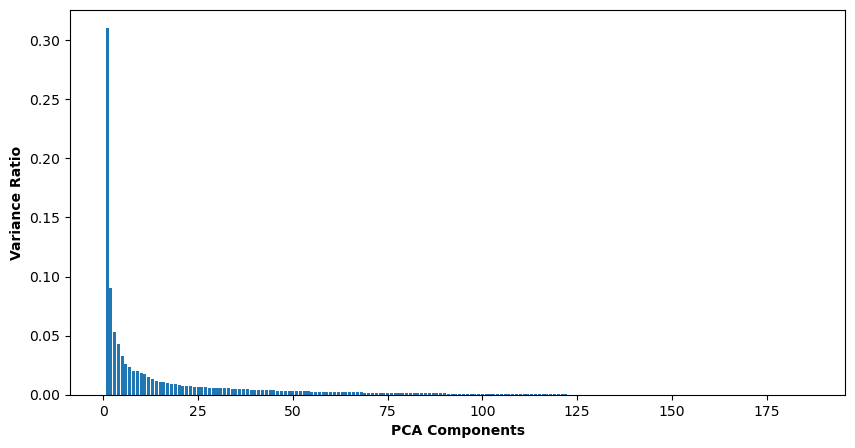

In [38]:
# Variance Ratio bar plot for each PCA components.
plt.figure(figsize = (10, 5))
ax = plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

plt.show()

In [39]:
# calculate the cumulative sum of explained variance ratios
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

org_col = list(grid_dropped.columns)

num_pc = np.argmax(cumulative_sum >= 0.8) + 1

pc_dict = {'Attribute': org_col}

pc_dict.update({f'PC_{i+1}':pca.components_[i] for i in range(num_pc)})

attributes_pca = pd.DataFrame(pc_dict)

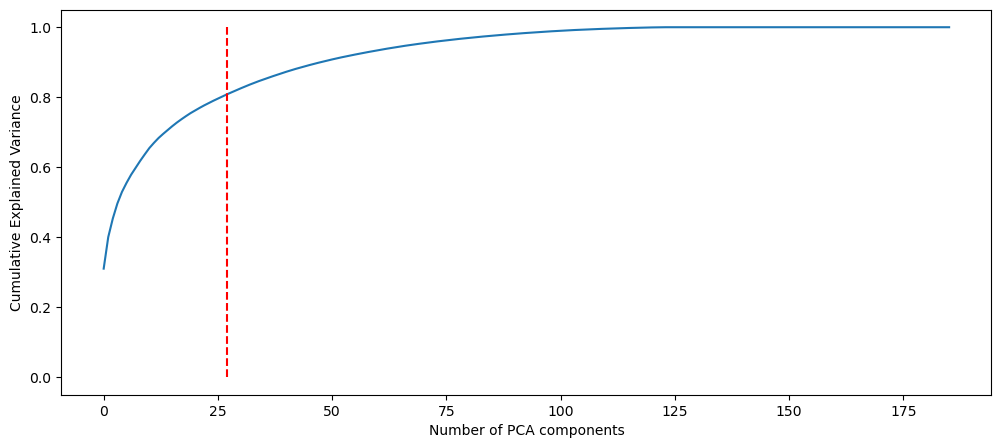

In [40]:
# Scree plot to visualize the Cumulative variance against the Number of components

fig = plt.figure(figsize = (12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=num_pc, ymax=1, ymin=0, colors="r", linestyles="--")
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [41]:
attributes_pca

Attribute      PC_1      PC_2      PC_3      PC_4  \
0                                row -0.010284 -0.001907 -0.024552 -0.017594   
1                                col  0.006590  0.028442  0.030504  0.016538   
2                      tess_area_IQR  0.068366 -0.069532  0.076588  0.079724   
3            tess_area_MeanWithinIQR  0.065104 -0.084608  0.044975  0.093513   
4                    tess_area_Theil  0.010191 -0.021253  0.134686 -0.108007   
..                               ...       ...       ...       ...       ...   
181  global_angular_betweeness_Theil -0.127856 -0.019158  0.023701  0.028244   
182                    strokes_count -0.130794 -0.019146  0.022836  0.027309   
183                stroke_length_IQR -0.127856 -0.019158  0.023701  0.028244   
184      stroke_length_MeanWithinIQR -0.127856 -0.019158  0.023701  0.028244   
185              stroke_length_Theil -0.127856 -0.019158  0.023701  0.028244   

         PC_5      PC_6      PC_7      PC_8      PC_9  ...     PC_18  \
0    0.013740 -0.053681 -0.036071 -0.007745 -0.004202  ... -0.007864   
1   -0.033924  0.094496  0.053042 -0.036341 -0.025668  ...  0.086511   
2   -0.029640  0.000808  0.064160 -0.054438 -0.023457  ...  0.018468   
3    0.040574  0.009830  0.072158 -0.039741 -0.003245  ...  0.044255   
4   -0.228369 -0.008414 -0.022873  0.008938 -0.060895  ... -0.123757   
..        ...       ...       ...       ...       ...  ...       ...   
181 -0.006034  0.006118 -0.008726  0.127838  0.001012  ...  0.003406   
182 -0.006725  0.004474 -0.005507  0.084395  0.000498  ...  0.002249   
183 -0.006034  0.006118 -0.008726  0.127838  0.001012  ...  0.003406   
184 -0.006034  0.006118 -0.008726  0.127838  0.001012  ...  0.003406   
185 -0.006034  0.006118 -0.008726  0.127838  0.001012  ...  0.003406   

        PC_19     PC_20     PC_21     PC_22     PC_23     PC_24     PC_25  \
0   -0.022216  0.050454  0.003073 -0.126578  0.042826  0.021506 -0.199840   
1   -0.072637 -0.029017 -0.059554 -0.008812 -0.163459 -0.120475 -0.123362   
2    0.004851 -0.008575  0.032453  0.019782  0.014710  0.084344  0.058542   
3    0.021387 -0.016794  0.010911 -0.009716  0.073732  0.097098  0.021420   
4   -0.067327 -0.051551  0.007832  0.029242 -0.111108  0.098779 -0.038592   
..        ...       ...       ...       ...       ...       ...       ...   
181 -0.004760 -0.005563 -0.001505 -0.000387  0.000457 -0.001962 -0.000106   
182 -0.002954 -0.003220 -0.001346  0.000137  0.000526 -0.001566  0.000118   
183 -0.004760 -0.005563 -0.001505 -0.000387  0.000457 -0.001962 -0.000106   
184 -0.004760 -0.005563 -0.001505 -0.000387  0.000457 -0.001962 -0.000106   
185 -0.004760 -0.005563 -0.001505 -0.000387  0.000457 -0.001962 -0.000106   

        PC_26     PC_27  
0    0.005566  0.504226  
1    0.049251  0.229187  
2   -0.082908  0.079566  
3   -0.117215  0.093173  
4    0.025197  0.042940  
..        ...       ...  
181  0.001167  0.001042  
182  0.000825  0.000118  
183  0.001167  0.001042  
184  0.001167  0.001042  
185  0.001167  0.001042  

[186 rows x 28 columns]

In [42]:
# Building the dataframe using Incremental PCA for better efficiency.

inc_pca = IncrementalPCA(n_components=num_pc)

In [43]:
# Fitting the scaled df on incremental pca

df_inc_pca = inc_pca.fit_transform(tessellation_scaled)
df_inc_pca

array([[-4.71862082e+01,  2.12032910e+00,  1.19313463e+01, ...,
        -4.59431393e+00,  1.60449754e-01,  1.43577747e+00],
       [-3.84040104e-01, -9.96046800e-01,  9.14153555e-01, ...,
         3.93984705e-01, -5.79517666e-01,  1.20474879e+00],
       [ 1.53447351e+00,  5.29546385e-01, -1.76398890e+00, ...,
        -9.17023979e-02,  7.20414168e-02,  2.72183592e-01],
       ...,
       [ 1.30277425e+00,  1.14005989e+00, -5.02775535e-01, ...,
        -7.86371977e-01,  1.76905914e-01, -6.21710529e-01],
       [ 6.02889471e-01,  1.27224526e-01,  2.01779305e+00, ...,
        -6.22192000e-01,  1.01929679e-02, -6.54553694e-01],
       [ 1.25754219e+00,  3.34219963e+00,  2.97727424e+00, ...,
         3.56149479e-01, -4.16242771e-01, -5.63034590e-01]])

In [44]:
components_df = pd.DataFrame(inc_pca.components_, columns=features)  # Adjust index based on n_components

In [78]:
# Writing the provided code with modifications to output to a text file

# Creating a string to capture the text that will be printed, for writing to a file
output_text = ""

# Assuming components_df is already defined as shown previously
number_of_features_to_describe = 15  # Change this to choose how many top features to describe for each component

# Iterating through each principal component
for component in components_df.index:
    component_description = f"Describing {component}:\n"
    output_text += component_description
    
    # Sorting the features by their contribution to the component
    sorted_features = components_df.loc[component].abs().sort_values(ascending=False)
    
    # Picking the top features
    top_features = sorted_features.head(number_of_features_to_describe).index
    contributions = sorted_features.head(number_of_features_to_describe).values
    
    # Printing out the top features and their contributions
    for feature, contribution in zip(top_features, contributions):
        feature_description = f" - {feature} with a loading of {contribution:.2f}\n"
        output_text += feature_description
    
    output_text += "\n"  # Add a new line for better readability

print(output_text)
# Writing the output to a text file
with open(f"../output/{place}/PC_summary.txt", "w") as file:
    file.write(output_text)


Describing 0:
 - edges_count with a loading of 0.13
 - strokes_count with a loading of 0.13
 - node_degree_MeanWithinIQR with a loading of 0.13
 - global_straightness_centrality_IQR_x with a loading of 0.13
 - straightness_400m_IQR with a loading of 0.13
 - global_straightness_centrality_MeanWithinIQR_x with a loading of 0.13
 - closeness_clustering_400m_Theil_x with a loading of 0.13
 - betweeness_centrality_edge_MeanWithinIQR with a loading of 0.13
 - meshedness_topo_5_IQR with a loading of 0.13
 - meshedness_eucl_500_MeanWithinIQR with a loading of 0.13
 - global_closeness_centrality_primal_MeanWithinIQR with a loading of 0.13
 - global_straightness_centrality_Theil_x with a loading of 0.13
 - clustering_Theil with a loading of 0.13
 - straightness_400m_MeanWithinIQR with a loading of 0.13
 - straightness_400m_Theil with a loading of 0.13

Describing 1:
 - buildings_neighbours_200_MeanWithinIQR with a loading of 0.18
 - building_count_y with a loading of 0.18
 - building_count_x wit

In [45]:
import pickle

with open(f"../output/{place}/pca.pickle", 'wb') as f:
    pickle.dump(components_df, f)

In [47]:
# Creating new dataframe with Principal components


df_pca = pd.DataFrame(df_inc_pca, columns=[f"PC_{i+1}" for i in range(num_pc)])

In [54]:
df_pca["row"] = grid_dropped["row"]
df_pca["col"] = grid_dropped["col"]

In [55]:
grid_dropped

row    col  tess_area_IQR  tess_area_MeanWithinIQR  tess_area_Theil  \
0       98.0  228.0   68799.158006             31109.135893         0.476648   
1      101.0  259.0    6229.354380              4071.757764         0.000000   
2      104.0  181.0     376.628517               922.025254         0.011901   
3      104.0  255.0     720.232657               817.889155         0.095015   
4      104.0  262.0     649.274626              1107.034233         0.025263   
...      ...    ...            ...                      ...              ...   
10811  265.0  188.0     300.738947               797.550464         0.038596   
10812  265.0  217.0    1350.202220              1890.654678         0.057723   
10813  267.0  212.0     687.466211               882.157249         0.048270   
10814  268.0  213.0    1109.629323               798.531131         0.161123   
10815  269.0  211.0     568.144618               587.067428         0.207082   

       tessellation_neighbours_IQR  tessellation_neighbours_MeanWithinIQR  \
0                         0.051367                               0.073323   
1                         0.070139                               0.166780   
2                         0.072901                               0.288511   
3                         0.083409                               0.346194   
4                         0.056921                               0.253383   
...                            ...                                    ...   
10811                     0.107412                               0.253136   
10812                     0.119724                               0.262917   
10813                     0.092750                               0.285953   
10814                     0.179223                               0.255244   
10815                     0.205595                               0.411092   

       tessellation_neighbours_Theil  tess_convexity_IQR  \
0                           0.045197            0.156249   
1                           0.000000            0.018497   
2                           0.008672            0.052924   
3                           0.006639            0.037930   
4                           0.004315            0.037923   
...                              ...                 ...   
10811                       0.026385            0.023138   
10812                       0.021983            0.032224   
10813                       0.010676            0.120526   
10814                       0.048548            0.067772   
10815                       0.024860            0.042122   

       tess_convexity_MeanWithinIQR  ...  global_angular_closeness_IQR  \
0                          0.902073  ...                      0.000000   
1                          0.957677  ...                      0.000192   
2                          0.960949  ...                      0.000192   
3                          0.955475  ...                      0.000192   
4                          0.969717  ...                      0.000192   
...                             ...  ...                           ...   
10811                      0.936680  ...                      0.000192   
10812                      0.949815  ...                      0.000192   
10813                      0.927641  ...                      0.000192   
10814                      0.938033  ...                      0.000192   
10815                      0.947546  ...                      0.000192   

       global_angular_closeness_MeanWithinIQR  global_angular_closeness_Theil  \
0                                    0.000000                        0.000000   
1                                    0.000748                        0.007617   
2                                    0.000748                        0.007617   
3                                    0.000748                        0.007617   
4                                    0.000748                        0.007617   
...                        

In [56]:
if len(grid_dropped) == len(df_pca):
    df_pca.index = grid_dropped.index
else:
    print("Error: The number of rows in grid_dropped and df_pca do not match.")

In [57]:
geo_col.reset_index()

row    col                                           geometry
0       98.0  224.0  POLYGON ((258725.960 675120.935, 258815.536 67...
1       98.0  228.0  POLYGON ((259084.263 675109.206, 259173.839 67...
2       99.0  224.0  POLYGON ((258726.683 675009.019, 258816.260 67...
3      100.0  261.0  POLYGON ((262041.803 674789.759, 262131.382 67...
4      101.0  259.0  POLYGON ((261863.396 674683.587, 261952.976 67...
...      ...    ...                                                ...
12168  265.0  188.0  POLYGON ((255617.406 656552.381, 255707.121 65...
12169  265.0  217.0  POLYGON ((258219.109 656466.586, 258308.823 65...
12170  267.0  212.0  POLYGON ((257771.974 656257.800, 257861.690 65...
12171  268.0  213.0  POLYGON ((257862.407 656143.130, 257952.123 65...
12172  269.0  211.0  POLYGON ((257683.691 656037.281, 257773.408 65...

[12173 rows x 3 columns]

In [64]:
df_pca_geometry = geo_col.reset_index().merge(df_pca, on=["row", "col"], how="left")

In [69]:
df_pca_geometry = df_pca_geometry.dropna()

In [70]:
df_pca_geometry

row    col                                           geometry  \
1       98.0  228.0  POLYGON ((259084.263 675109.206, 259173.839 67...   
4      101.0  259.0  POLYGON ((261863.396 674683.587, 261952.976 67...   
5      104.0  181.0  POLYGON ((254878.396 674577.338, 254967.973 67...   
6      104.0  255.0  POLYGON ((261507.324 674359.360, 261596.906 67...   
7      104.0  262.0  POLYGON ((262134.399 674339.263, 262223.981 67...   
...      ...    ...                                                ...   
12168  265.0  188.0  POLYGON ((255617.406 656552.381, 255707.121 65...   
12169  265.0  217.0  POLYGON ((258219.109 656466.586, 258308.823 65...   
12170  267.0  212.0  POLYGON ((257771.974 656257.800, 257861.690 65...   
12171  268.0  213.0  POLYGON ((257862.407 656143.130, 257952.123 65...   
12172  269.0  211.0  POLYGON ((257683.691 656037.281, 257773.408 65...   

            PC_1      PC_2       PC_3      PC_4      PC_5      PC_6      PC_7  \
1     -47.186208  2.120329  11.931346 -3.895301  2.844737 -1.081926  0.462450   
4      -0.384040 -0.996047   0.914154 -7.114937  1.278495  0.634043 -0.732728   
5       1.534474  0.529546  -1.763989 -1.180721  0.689467 -1.468957  0.182930   
6       0.772152  2.892817   3.870703 -2.600116  0.699332 -1.350347  1.126805   
7       1.659454  1.721584  -1.691558 -2.023369 -0.318357  2.250311 -0.883681   
...          ...       ...        ...       ...       ...       ...       ...   
12168   2.098156  3.241927  -1.097102  0.485086 -1.393753  3.766221  1.645503   
12169   1.940098  0.322091   0.445988  3.100244 -2.010825  3.940597  0.262862   
12170   1.302774  1.140060  -0.502776 -1.244469  2.431153  1.641391  0.043814   
12171   0.602889  0.127225   2.017793 -2.552481  3.564246  0.813460  0.595903   
12172   1.257542  3.342200   2.977274 -0.244601  1.844400  0.366809 -0.016439   

       ...     PC_18     PC_19     PC_20     PC_21     PC_22     PC_23  \
1      ... -0.730510 -4.127739 -1.730420 -0.685447  3.114018 -0.597541   
4      ... -1.774769 -0.724746  1.213512 -2.676479  2.133928  0.296434   
5      ...  0.763426 -0.617365 -1.185211 -0.200608  1.390776 -1.167399   
6      ...  0.615430  1.553074  1.780327 -1.483750  3.333268 -0.302141   
7      ...  0.195483  0.461900  1.110280  3.295632  0.018921  0.275279   
...    ...       ...       ...       ...       ...       ...       ...   
12168  ... -0.424494 -0.128764 -0.011247  0.025538 -0.182523  0.205634   
12169  ... -5.523574  1.458897  0.651641 -5.496024  1.310430  0.646498   
12170  ...  0.197991 -0.585203  0.468089 -0.900887  2.547379 -1.471341   
12171  ... -1.025143 -0.498990 -0.126928 -1.218912  0.566651  0.029609   
12172  ... -0.243755  0.827855 -0.202522 -0.259609  1.351600 -0.773506   

          PC_24     PC_25     PC_26      PC_27  
1     -3.486531 -4.594314  0.160450   1.435777  
4      1.478238  0.393985 -0.579518   1.204749  
5      0.182934 -0.091702  0.072041   0.272184  
6     -1.683541  0.125033 -0.616045   0.019254  
7     -0.232028  2.213812  9.521707  10.330615  
...         ...       ...       ...        ...  
12168 -0.702199 -1.286752  1.292129  -0.159368  
12169  2.950085 -0.366100  4.444087  -0.041397  
12170 -0.688571 -0.786372  0.176906  -0.621711  
12171 -0.231622 -0.622192  0.010193  -0.654554  
12172  0.041049  0.356149 -0.416243  -0.563035  

[10816 rows x 30 columns]

In [71]:
df_pca = df_pca_geometry.drop(columns=["row", "col", "geometry"])

In [73]:
columns_to_plot = df_pca_geometry.dropna().columns.drop('geometry')

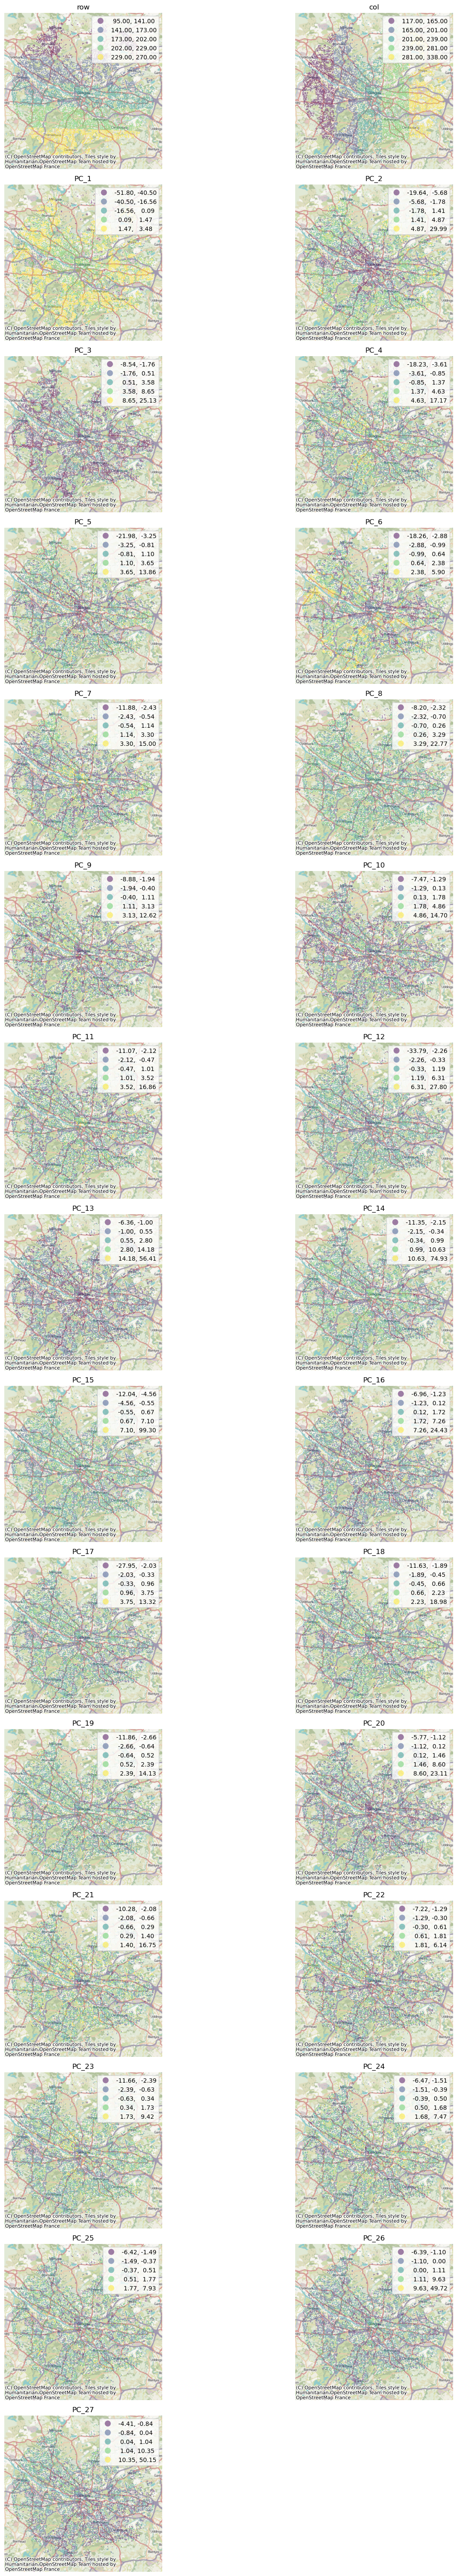

In [74]:
# Number of rows and columns for the subplot grid
n_cols = 2  # You can adjust this based on your preference
n_rows = (len(columns_to_plot) + 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Flatten axes array for easy iteration, if there's more than one row
axes = axes.flatten() if n_rows > 1 else [axes]

# Loop through the columns and create a plot for each
for i, column in enumerate(columns_to_plot):
    # Plot with translucent colors
    df_pca_geometry.dropna().plot(column=column, scheme="natural_breaks", ax=axes[i], legend=True, alpha=0.5)  # Adjust alpha for translucency

    # Add Contextily basemap
    ctx.add_basemap(axes[i], crs=df_pca_geometry.crs.to_string())

    axes[i].set_title(column)
    axes[i].set_axis_off()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [85]:
df_pca_geometry

row    col                                           geometry  \
1       98.0  228.0  POLYGON ((259084.263 675109.206, 259173.839 67...   
4      101.0  259.0  POLYGON ((261863.396 674683.587, 261952.976 67...   
5      104.0  181.0  POLYGON ((254878.396 674577.338, 254967.973 67...   
6      104.0  255.0  POLYGON ((261507.324 674359.360, 261596.906 67...   
7      104.0  262.0  POLYGON ((262134.399 674339.263, 262223.981 67...   
...      ...    ...                                                ...   
12168  265.0  188.0  POLYGON ((255617.406 656552.381, 255707.121 65...   
12169  265.0  217.0  POLYGON ((258219.109 656466.586, 258308.823 65...   
12170  267.0  212.0  POLYGON ((257771.974 656257.800, 257861.690 65...   
12171  268.0  213.0  POLYGON ((257862.407 656143.130, 257952.123 65...   
12172  269.0  211.0  POLYGON ((257683.691 656037.281, 257773.408 65...   

            PC_1      PC_2       PC_3      PC_4      PC_5      PC_6      PC_7  \
1     -47.186208  2.120329  11.931346 -3.895301  2.844737 -1.081926  0.462450   
4      -0.384040 -0.996047   0.914154 -7.114937  1.278495  0.634043 -0.732728   
5       1.534474  0.529546  -1.763989 -1.180721  0.689467 -1.468957  0.182930   
6       0.772152  2.892817   3.870703 -2.600116  0.699332 -1.350347  1.126805   
7       1.659454  1.721584  -1.691558 -2.023369 -0.318357  2.250311 -0.883681   
...          ...       ...        ...       ...       ...       ...       ...   
12168   2.098156  3.241927  -1.097102  0.485086 -1.393753  3.766221  1.645503   
12169   1.940098  0.322091   0.445988  3.100244 -2.010825  3.940597  0.262862   
12170   1.302774  1.140060  -0.502776 -1.244469  2.431153  1.641391  0.043814   
12171   0.602889  0.127225   2.017793 -2.552481  3.564246  0.813460  0.595903   
12172   1.257542  3.342200   2.977274 -0.244601  1.844400  0.366809 -0.016439   

       ...     PC_18     PC_19     PC_20     PC_21     PC_22     PC_23  \
1      ... -0.730510 -4.127739 -1.730420 -0.685447  3.114018 -0.597541   
4      ... -1.774769 -0.724746  1.213512 -2.676479  2.133928  0.296434   
5      ...  0.763426 -0.617365 -1.185211 -0.200608  1.390776 -1.167399   
6      ...  0.615430  1.553074  1.780327 -1.483750  3.333268 -0.302141   
7      ...  0.195483  0.461900  1.110280  3.295632  0.018921  0.275279   
...    ...       ...       ...       ...       ...       ...       ...   
12168  ... -0.424494 -0.128764 -0.011247  0.025538 -0.182523  0.205634   
12169  ... -5.523574  1.458897  0.651641 -5.496024  1.310430  0.646498   
12170  ...  0.197991 -0.585203  0.468089 -0.900887  2.547379 -1.471341   
12171  ... -1.025143 -0.498990 -0.126928 -1.218912  0.566651  0.029609   
12172  ... -0.243755  0.827855 -0.202522 -0.259609  1.351600 -0.773506   

          PC_24     PC_25     PC_26      PC_27  
1     -3.486531 -4.594314  0.160450   1.435777  
4      1.478238  0.393985 -0.579518   1.204749  
5      0.182934 -0.091702  0.072041   0.272184  
6     -1.683541  0.125033 -0.616045   0.019254  
7     -0.232028  2.213812  9.521707  10.330615  
...         ...       ...       ...        ...  
12168 -0.702199 -1.286752  1.292129  -0.159368  
12169  2.950085 -0.366100  4.444087  -0.041397  
12170 -0.688571 -0.786372  0.176906  -0.621711  
12171 -0.231622 -0.622192  0.010193  -0.654554  
12172  0.041049  0.356149 -0.416243  -0.563035  

[10816 rows x 30 columns]

In [86]:
df_pca_geometry.to_parquet(f"../output/{place}/df_pca_geom.pq")

In [87]:
import pickle

with open(f"../output/{place}/df_pca_geometry.pickle", 'wb') as f:
    pickle.dump(df_pca_geometry, f)

In [88]:
df_pca_with_uID = df_pca.copy()

In [89]:
df_pca_with_uID["uID"] = [str(i) for i in grid_dropped.index]

In [90]:
# # Calculating Hopkins score to know whether the data is good for clustering or not.

# def hopkins(X):
#     d = X.shape[1]
#     n = len(X)
#     m = int(0.1 * n) 
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
#     rand_X = sample(range(0, n, 1), m)
 
#     ujd = []
#     wjd = []
#     for j in range(0, m):
#         u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
#         ujd.append(u_dist[0][1])
#         w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
#         wjd.append(w_dist[0][1])
 
#     HS = sum(ujd) / (sum(ujd) + sum(wjd))
#     if isnan(HS):
#         print(ujd, wjd)
#         HS = 0
 
#     return HS


In [91]:
# # Hopkins score
# Hopkins_score=round(hopkins(df_pca),2)

In [92]:
# print(Hopkins_score)

The Hopkins statistic (introduced by Brian Hopkins and John Gordon Skellam) is a way of measuring the cluster tendency of a data set.[1] It belongs to the family of sparse sampling tests. It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed.[2] A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.[3]

In [93]:
len(df_pca_with_uID)

10816

In [94]:
df_pca.to_parquet(f"../output/{place}/df_pca.pq")